#  11.1 문서요약 : DTM, TF-IDF

In [1]:
docs = '''오늘은 매우 좋은 날씨 입니다
내일도 매우 좋은 날씨를 기대합니다
토픽 모형을 이용하여 문서를 모형에 적합시켜 문서 내용을 분석하는 방법은 매우 쉽다고 생각할 수 있습니다'''
doc_list = docs.split('\n')
doc_list = [v for v in doc_list if v]
print(len(doc_list))

3


In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 25.3 MB/s eta 0:00:00


In [3]:
import konlpy
docs_list =[]
for doc in doc_list:
    nouns = konlpy.tag.Okt().nouns(doc)
    docs_list.append(' '.join(nouns))
print(docs_list)

['오늘 매우 날씨', '내일 매우 날씨', '토픽 모형 이용 문서 모형 적합 문서 내용 분석 방법 매우 생각 수']


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer() #vocabulary=vocab 지정 또는 미지정 가능
dtm = vect.fit_transform(docs_list).toarray()
vocab = vect.get_feature_names_out()
pd.DataFrame(dtm, columns=vocab)

,날씨,내용,내일,매우,모형,문서,방법,분석,생각,오늘,이용,적합,토픽
0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,1,2,2,1,1,1,0,1,1,1


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(vocabulary=vocab)
tfidf = tfidfv.fit_transform(docs_list).toarray()
pd.DataFrame(tfidf, columns=vocab)

,날씨,내용,내일,매우,모형,문서,방법,분석,생각,오늘,이용,적합,토픽
0,0.547832,0.000000,0.000000,0.425441,0.000000,0.000000,0.000000,0.000000,0.000000,0.720333,0.000000,0.000000,0.000000
1,0.547832,0.000000,0.720333,0.425441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.255248,0.000000,0.150754,0.510496,0.510496,0.255248,0.255248,0.255248,0.000000,0.255248,0.255248,0.255248


In [6]:
import numpy as np
tfidf_order = np.flip(np.argsort(tfidf, axis=-1), axis=-1)
topics =[]
n_top = 2
for line in tfidf_order:
  topic = [vocab[x] for x in line[:n_top]]
  topics.append(topic)
df = pd.DataFrame(topics)
df

,0,1
0,오늘,날씨
1,내일,날씨
2,문서,모형


# 11.2 주제 식별 : LSA, LDA

In [7]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(tfidf)
len(svd_model.components_)

2

In [8]:
svd_model.components_

array([[ 0.62281757,  0.03739875,  0.40946513,  0.5057617 ,  0.07479749,
         0.07479749,  0.03739875,  0.03739875,  0.03739875,  0.40946513,
         0.03739875,  0.03739875,  0.03739875],
       [-0.140082  ,  0.25321296, -0.0920955 ,  0.04076548,  0.50642592,
         0.50642592,  0.25321296,  0.25321296,  0.25321296, -0.0920955 ,
         0.25321296,  0.25321296,  0.25321296]])

In [9]:
def get_topics(components, feature_names, n=3):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(3)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(svd_model.components_,vocab)

Topic 1: [('날씨', 0.623), ('매우', 0.506), ('내일', 0.409)]
Topic 2: [('문서', 0.506), ('모형', 0.506), ('토픽', 0.253)]


In [10]:
# LDA 모형 적합
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components = 2, max_iter = 20, random_state = 20)
lda_model.fit_transform(tfidf)
get_topics(lda_model.components_,vocab)

Topic 1: [('문서', 1.001), ('모형', 1.001), ('토픽', 0.748)]
Topic 2: [('날씨', 1.581), ('매우', 1.358), ('내일', 1.206)]


In [11]:
# 문서별 주제
pd.DataFrame(lda_model.transform(tfidf), index = ['문서 0', '문서 1', '문서 2'], columns=['1 주제', '2 주제'])

,1 주제,2 주제
문서 0,0.198199,0.801801
문서 1,0.198199,0.801801
문서 2,0.847348,0.152652


In [12]:
!pip install gensim

In [13]:
#토큰화된 문서의 리스트 형태로 변경
tdoc_list = []
for doc in docs_list:
    tdoc_list.append(doc.split())
tdoc_list

[['오늘', '매우', '날씨'],
 ['내일', '매우', '날씨'],
 ['토픽', '모형', '이용', '문서', '모형', '적합', '문서', '내용', '분석', '방법', '매우', '생각', '수']]

In [14]:
from gensim import corpora
g_dictionary = corpora.Dictionary(tdoc_list)
g_corpus = [g_dictionary.doc2bow(tdoc) for tdoc in tdoc_list]
print(g_dictionary.token2id)
print(g_dictionary.token2id.items())
print(g_corpus)

{'날씨': 0, '매우': 1, '오늘': 2, '내일': 3, '내용': 4, '모형': 5, '문서': 6, '방법': 7, '분석': 8, '생각': 9, '수': 10, '이용': 11, '적합': 12, '토픽': 13}
dict_items([('날씨', 0), ('매우', 1), ('오늘', 2), ('내일', 3), ('내용', 4), ('모형', 5), ('문서', 6), ('방법', 7), ('분석', 8), ('생각', 9), ('수', 10), ('이용', 11), ('적합', 12), ('토픽', 13)])
[[(0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (3, 1)], [(1, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [15]:
from gensim.models.ldamodel import LdaModel
NUM_TOPICS = 2
ldamodel = LdaModel(corpus=g_corpus, num_topics = NUM_TOPICS, id2word=g_dictionary, passes=15)
lda_topics = ldamodel.print_topics(num_words=3)
lda_topics

[(0, '0.193*"매우" + 0.191*"날씨" + 0.115*"내일"'),
 (1, '0.125*"모형" + 0.125*"문서" + 0.075*"내용"')]

# 11.3 토픽모형 사례 : 위키백과 10개 문서 토픽 분석

1.전체 문서들에 대한 한글형태소 분석기 등의 전처리를 통하여 corpus(문서리스트)와 tdoc_list(문서별토큰리스트)을 만든다.

2.sklearn의 CountVectorizer를 이용해서 DTM을 구하고, TfidfVectorizer 클래스로 TF-IDF 행렬을 구하여 토픽과 유사성 탐색한다.

3.Gensim 라이브러리를 이용하여 LDA 모형을 학습시켜 문서별 토픽과 토픽별 키워드 등을 분석한다.

4.wordcloud, pyLDAvis, Matplotlib 등으로 시각화 표현

## 가.전처리 후 토큰과 코퍼스 만들기

In [16]:
# 분석대상 문서들 가져오기 :
!wget https://raw.githubusercontent.com/byungjooyoo/Dataset/main/kowiki_10.txt

--2024-05-11 23:14:17--  https://raw.githubusercontent.com/byungjooyoo/Dataset/main/kowiki_10.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55488 (54K) [text/plain]
Saving to: ‘kowiki_10.txt’

kowiki_10.txt       100%[===================>]  54.19K  --.-KB/s    in 0.02s   

2024-05-11 23:14:17 (2.79 MB/s) - ‘kowiki_10.txt’ saved [55488/55488]



In [17]:
# 문서형태 탐색
with open("kowiki_10.txt") as f:
  data = f.read()
docs = data.split("\n\n\n\n")
docs = [ doc for doc in docs if doc ]
len(docs)

10

In [18]:
# 문서별로 한글 형태소 분석기로 전처리 후 형태소만 추출하고, Stop words 제거, 한글자 제거 후 tdoc_list으로 담기
import konlpy
tdoc_list=[]
doc_list =[]
for doc in docs:
  morp = konlpy.tag.Okt().nouns(doc)
  morp = [x for x in morp if len(x) > 1]
  tdoc_list.append(morp)
  doc_list.append(' '.join(morp))

print(doc_list)
print(tdoc_list)

['지미 카터 제임스 지미 카터 주니어 민주당 출신 미국 대통령 지미 카터 조지아주 섬터 카운티 플레인스 마을 조지아 공과 대학교 졸업 해군 전함 원자력 잠수함 승무원 미국 해군 대위 이후 땅콩 면화 별명 땅콩 농부 조지아 상원 의원 선거 낙선 하나 선거 부정선거 입증 당선 조지아 지사 선거 낙선 조지아 지사 역임 대통령 조지아주 상원의원 조지아 지사 근무 조지아 지사 미국 흑인 용법 대통령 선거 민주당 후보 출마 도덕 주의 정책 포드 당선 카터 대통령 에너지 개발 촉구 공화당 반대 무산 카터 이집트 이스라엘 조정 캠프 데이비드 안와르 사다트 대통령 메나헴 수상 중동 평화 캠프데이비드 협정 체결 공화당 미국 유대인 단체 반발 백악관 양국 간의 평화조약 또한 소련 전략 무기 제한 협상 조인 카터 후반 당시 대한민국 인권 후진국 국민 인권 위해 노력 취임 이후 계속 도덕 정치 이란 미국 대사관 인질 사건 인질 구출 실패 이유 대통령 선거 공화당 로널드 레이건 후보 재선 또한 임기 말기 소련 아프가니스탄 침공 사건 올림픽 국가 보이콧 지미 카터 대한민국 관계 영향 대통령 하나 인권 문제 미군 철수 문제 한미 관계 대한민국 대한 북한 위협 대비 한미연합사 창설 단계 미군 철수 미군 사령부 정보기관 의회 반대 미군 완전 철수 대신 감축 또한 박정희 정권 인권 문제 논란 불협화음 하순 대한민국 방문 관계 다소 회복 대한민국 정치 격변 당시 대통령 대해 태도 대한민국 고조 반미 운동 원인 박정희 대통령 김재규 중앙 정보 부장 살해 대해 사건 충격 사이러스 밴스 국무장관 사절 파견 군사 반란 쿠데타 대해 초기 비난 미국 정부 신군부 설득 한계 묵인 태도 보이 퇴임 이후 민간 자원 적극 활용 비영리 기구 카터 재단 설립 민주주의 실현 위해 세계 선거 감시 활동 기니 벌레 드라쿤쿠르스 질병 방재 위해 미국 빈곤층 지원 활동 사랑 집짓기 운동 국제 분쟁 중재 활동 카터 카터 행정부 이후 미국 북핵 위기 코소보 전쟁 이라크 전쟁 미국 군사 행동 최후 선택 전통 사고 군사 행동 선행

## 나.Sklearn으로 DTM, TF-IDF를 만들어 탐색하기

In [19]:
# DTM 구하기, corpus 문서단위 리스트,
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
vect = CountVectorizer()
dtm = vect.fit_transform(doc_list).toarray()
vocab = vect.get_feature_names_out()
pd.DataFrame(dtm, columns=vocab)

,가공,가까이,가나다,가라,가산,가설,가스,가우스,가운데,가장,...,후보,후진국,훈민정음,훗날,흑인,흡수,흡열반응,흥미,희곡,힐베르트
0,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,1,0,0,4,...,0,0,0,0,0,2,2,0,0,0
6,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,2,0,2,...,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# TFIDF 도표 구하기 : 딕셔너리는 vocab, 분석대상은 corpus
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(vocabulary=vocab)
tfidf = tfidfv.fit_transform(doc_list).toarray()
pd.DataFrame(tfidf, columns=vocab)

,가공,가까이,가나다,가라,가산,가설,가스,가우스,가운데,가장,...,후보,후진국,훈민정음,훗날,흑인,흡수,흡열반응,흥미,희곡,힐베르트
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.05183,0.025915,0.000000,0.000000,0.025915,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.022825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019403
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.030403,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060805,0.060805,0.000000
4,0.000000,0.000000,0.046108,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.011997,0.000000,0.000000,0.000000,0.000000,0.011997,0.011997,0.000000,0.00000,0.035689,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.023993,0.023993,0.000000,0.000000,0.000000
6,0.000000,0.050834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.037807,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023953,0.00000,0.017815,...,0.00000,0.000000,0.000000,0.011977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.255101,0.000000,0.000000,0.000000,0.05102,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130116
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 문서별 토픽 탐색

In [21]:
import numpy as np
tfidf_order = np.flip(np.argsort(tfidf, axis=-1), axis=-1)
tfidf_order

array([[ 363,  241, 1163, ...,  828,  829,    0],
       [ 628,  478,  405, ...,  842,  843,    0],
       [ 535,  628,  533, ...,  892,  893,    0],
       ...,
       [ 415,  313,  431, ...,  857,  860,    0],
       [1127, 1090,    4, ...,  887,  888,    0],
       [ 807,  810,  396, ...,  885,  886,    0]])

In [22]:
# TF-IDF 문서별 토픽 추출 - 다른 문서와 차별화되는 유니크한 주제
topics =[]
n_top = 10 # topic 개수
for line in tfidf_order:
  topic = [vocab[x] for x in line[:n_top]]
  topics.append(topic)

df = pd.DataFrame(topics)
df

,0,1,2,3,4,5,6,7,8,9
0,미국,대통령,카터,인권,대한민국,조지아,선거,해결,북한,군사
1,수학,분야,발전,공간,구조,연구,개념,기하학,대한,탐구
2,상수,수학,상관관계,물리,정의,우리,골롬,딕맨,변량,수이
3,문학,감상,작품,이야기,문예학,사람,범주,예술,대중문학,씌어
4,목록,국가,기준,나라,협약,몬테비데오,포함,정보,조건,대한
5,화학,물질,원자,화합물,원소,결합,반응,금속,유기,에너지
6,체첸,공화국,러시아,러시아인,체첸인,인구,인구시인,제국,지역,민족
7,방정식,맥스웰,법칙,논문,자기,전하,전류,전자기파,헤비사이드,유도
8,초월수,집합,가산,문제,증명,초월,수임,대수,힐베르트,제시
9,음계,음악,반음계,온음계,이름,전통,서양,장음계,음정,계이름


## 다.Gensim으로 LDA 모형에 적합

In [23]:
# LDA 모형 적합, g_dictionary 사전 만들고, g_corpus(word, count)로 정리하고, ldamodel 객체 생성 (토픽4)
import gensim
g_dictionary = gensim.corpora.Dictionary(tdoc_list)
g_corpus = [g_dictionary.doc2bow(text) for text in tdoc_list]
ldamodel = gensim.models.ldamodel.LdaModel(corpus=g_corpus, id2word=g_dictionary, num_topics=4, passes=15)
# ldamodel.print_topics()

### 문서별 토픽 정리

In [24]:
def format_topics_sentences(ldamodel=None, g_corpus=g_corpus, tokens=tdoc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[g_corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df =pd.concat([sent_topics_df, pd.DataFrame([[topic_num, round(prop_topic, 3), topic_keywords],])], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['주요토픽', '토픽 기여도', '주요 토픽 키워드']

    # Add original text to the end of the output
    contents = pd.Series(tdoc_list)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
# 문서별 토픽정리
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, g_corpus=g_corpus, tokens=tdoc_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['문서번호', '주요토픽', '토픽 기여도', '키워드', '토큰']
df_dominant_topic

,문서번호,주요토픽,토픽 기여도,키워드,토큰
0,0,1,0.998,"방정식, 맥스웰, 수학, 대한, 미국, 법칙, 개념, 연구, 위해, 자기","[지미, 카터, 제임스, 지미, 카터, 주니어, 민주당, 출신, 미국, 대통령, 지..."
1,1,1,0.999,"방정식, 맥스웰, 수학, 대한, 미국, 법칙, 개념, 연구, 위해, 자기","[수학, 수학, 구조, 공간, 변화, 미적분, 개념, 학문, 현대, 수학, 형식, ..."
2,2,0,0.984,"음계, 상수, 음악, 수학, 반음계, 전통, 이름, 온음계, 다른, 포함","[수학, 상수, 수학, 상수, 변량, 변수, 반대말, 물리, 상수, 달리, 수학, ..."
3,3,3,0.998,"화학, 물질, 원소, 원자, 문학, 화합물, 결합, 국가, 포함, 반응","[문학, 문학, 언어, 예술, 표현, 제재, 의미, 출하, 인간, 사회, 묘사, 예..."
4,4,3,0.995,"화학, 물질, 원소, 원자, 문학, 화합물, 결합, 국가, 포함, 반응","[나라, 목록, 문서, 나라, 목록, 세계, 나라, 현황, 주권, 승인, 정보, 개..."
5,5,3,0.999,"화학, 물질, 원소, 원자, 문학, 화합물, 결합, 국가, 포함, 반응","[화학, 화학, 물질, 성질, 조성, 구조, 변화, 수반, 에너지, 변화, 연구, ..."
6,6,2,0.994,"초월수, 체첸, 집합, 러시아, 공화국, 문제, 증명, 가산, 존재, 체첸인","[체첸, 공화국, 체첸, 공화국, 체첸, 러시아, 공화국, 체첸, 사용, 언어, 체..."
7,7,1,0.999,"방정식, 맥스웰, 수학, 대한, 미국, 법칙, 개념, 연구, 위해, 자기","[맥스웰, 방정식, 맥스웰, 방정식, 전기, 자기, 발생, 전기장, 자기장, 전하,..."
8,8,2,0.994,"초월수, 체첸, 집합, 러시아, 공화국, 문제, 증명, 가산, 존재, 체첸인","[초월수, 초월수, 계수, 유리수, 방정식, 해도, 복소수, 방정식, 수인, 대수,..."
9,9,0,0.993,"음계, 상수, 음악, 수학, 반음계, 전통, 이름, 온음계, 다른, 포함","[음계, 음계, 음악, 음높이, 순서, 집합, 악곡, 주로, 구성, 음계, 종류, ..."


### 토픽별 키워드 정리

In [26]:
# 토픽별 키워드와 관련 토큰 정리
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('주요토픽')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['토픽 기여도'], ascending=False).head(1)], axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['토픽번호', "토픽 기여도", "키워드", "관련 토큰"]

# Show
sent_topics_sorteddf_mallet.head(10)

,토픽번호,토픽 기여도,키워드,관련 토큰
0,0,0.993,"음계, 상수, 음악, 수학, 반음계, 전통, 이름, 온음계, 다른, 포함","[음계, 음계, 음악, 음높이, 순서, 집합, 악곡, 주로, 구성, 음계, 종류, 분위기, 음계, 각각, 위치, 도수, 음계, 음계, 포함, 음정, 따라서, 이름, 음계, ..."
1,1,0.999,"방정식, 맥스웰, 수학, 대한, 미국, 법칙, 개념, 연구, 위해, 자기","[수학, 수학, 구조, 공간, 변화, 미적분, 개념, 학문, 현대, 수학, 형식, 논리, 이용, 공리, 구성, 추상, 구조, 연구, 학문, 기도, 수학, 구조, 발전, 과정..."
2,2,0.994,"초월수, 체첸, 집합, 러시아, 공화국, 문제, 증명, 가산, 존재, 체첸인","[체첸, 공화국, 체첸, 공화국, 체첸, 러시아, 공화국, 체첸, 사용, 언어, 체첸어, 러시아어, 체첸어, 캅카스, 제어, 북동, 캅카스, 제어, 그룹, 인구시어, 매우,..."
3,3,0.999,"화학, 물질, 원소, 원자, 문학, 화합물, 결합, 국가, 포함, 반응","[화학, 화학, 물질, 성질, 조성, 구조, 변화, 수반, 에너지, 변화, 연구, 자연과학, 분야, 물리학, 역시, 물질, 학문, 물리학, 원소, 화합물, 모두, 포함, 물..."


## 라.토픽 분석결과 시각화

In [27]:
!wget https://github.com/byungjooyoo/Dataset/raw/main/heart.png

--2024-05-11 23:14:27--  https://github.com/byungjooyoo/Dataset/raw/main/heart.png
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/byungjooyoo/Dataset/main/heart.png [following]
--2024-05-11 23:14:27--  https://raw.githubusercontent.com/byungjooyoo/Dataset/main/heart.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33907 (33K) [image/png]
Saving to: ‘heart.png’

heart.png           100%[===================>]  33.11K  --.-KB/s    in 0.005s  

2024-05-11 23:14:27 (7.18 MB/s) - ‘heart.png’ saved [33907/33907]



In [28]:
# Colab 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
!apt install fonts-nanum fonts-nanum-extra
mpl.font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
mpl.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-extra
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 31.4 MB in 1s (28.8 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (202

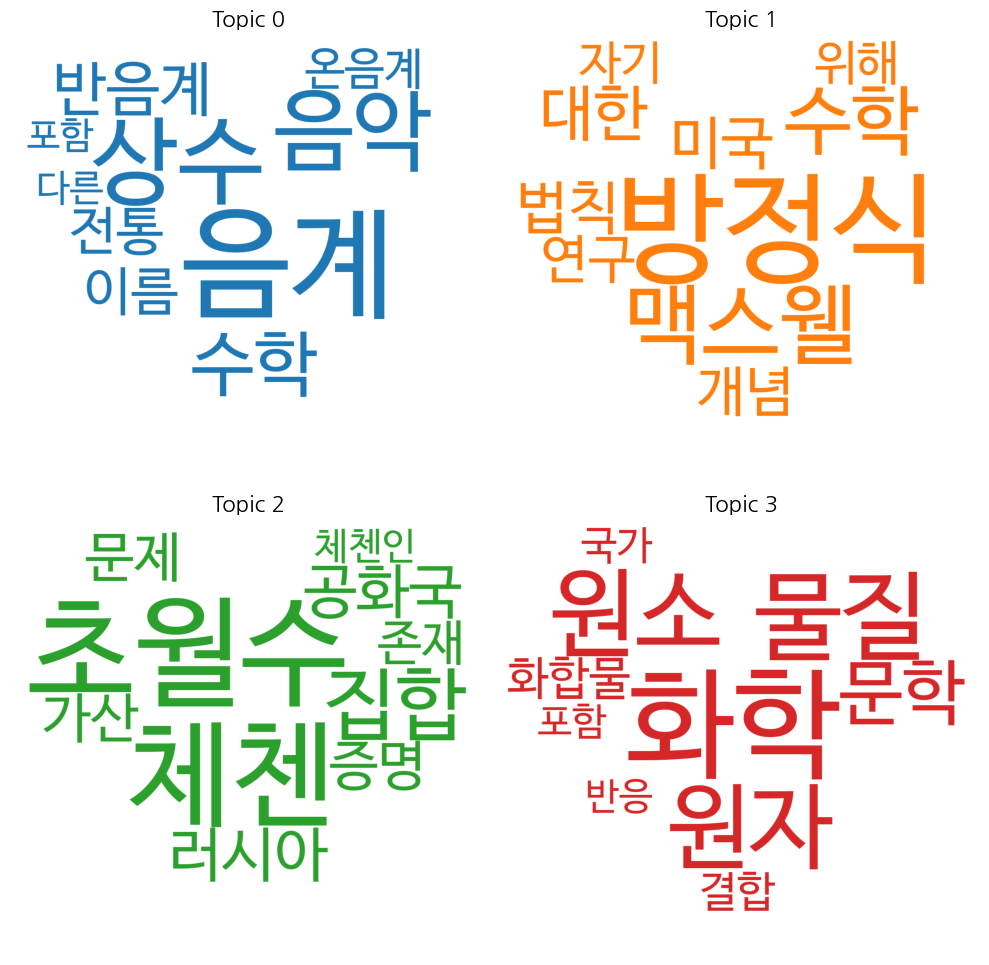

In [29]:
# 토픽별 워드크라우딩
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import numpy as np
from PIL import Image

# 이미지 마스킹 처리 위한 np.array로 변환
icon = Image.open('heart.png').convert("RGBA")
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
cloud = WordCloud(background_color='white',
                  font_path=fontpath,
                  width=2500,
                  height=1800,
                  mask=mask,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
# plt.savefig('토픽1.png')
plt.show()

<ipython-input-30-faac311fb89e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


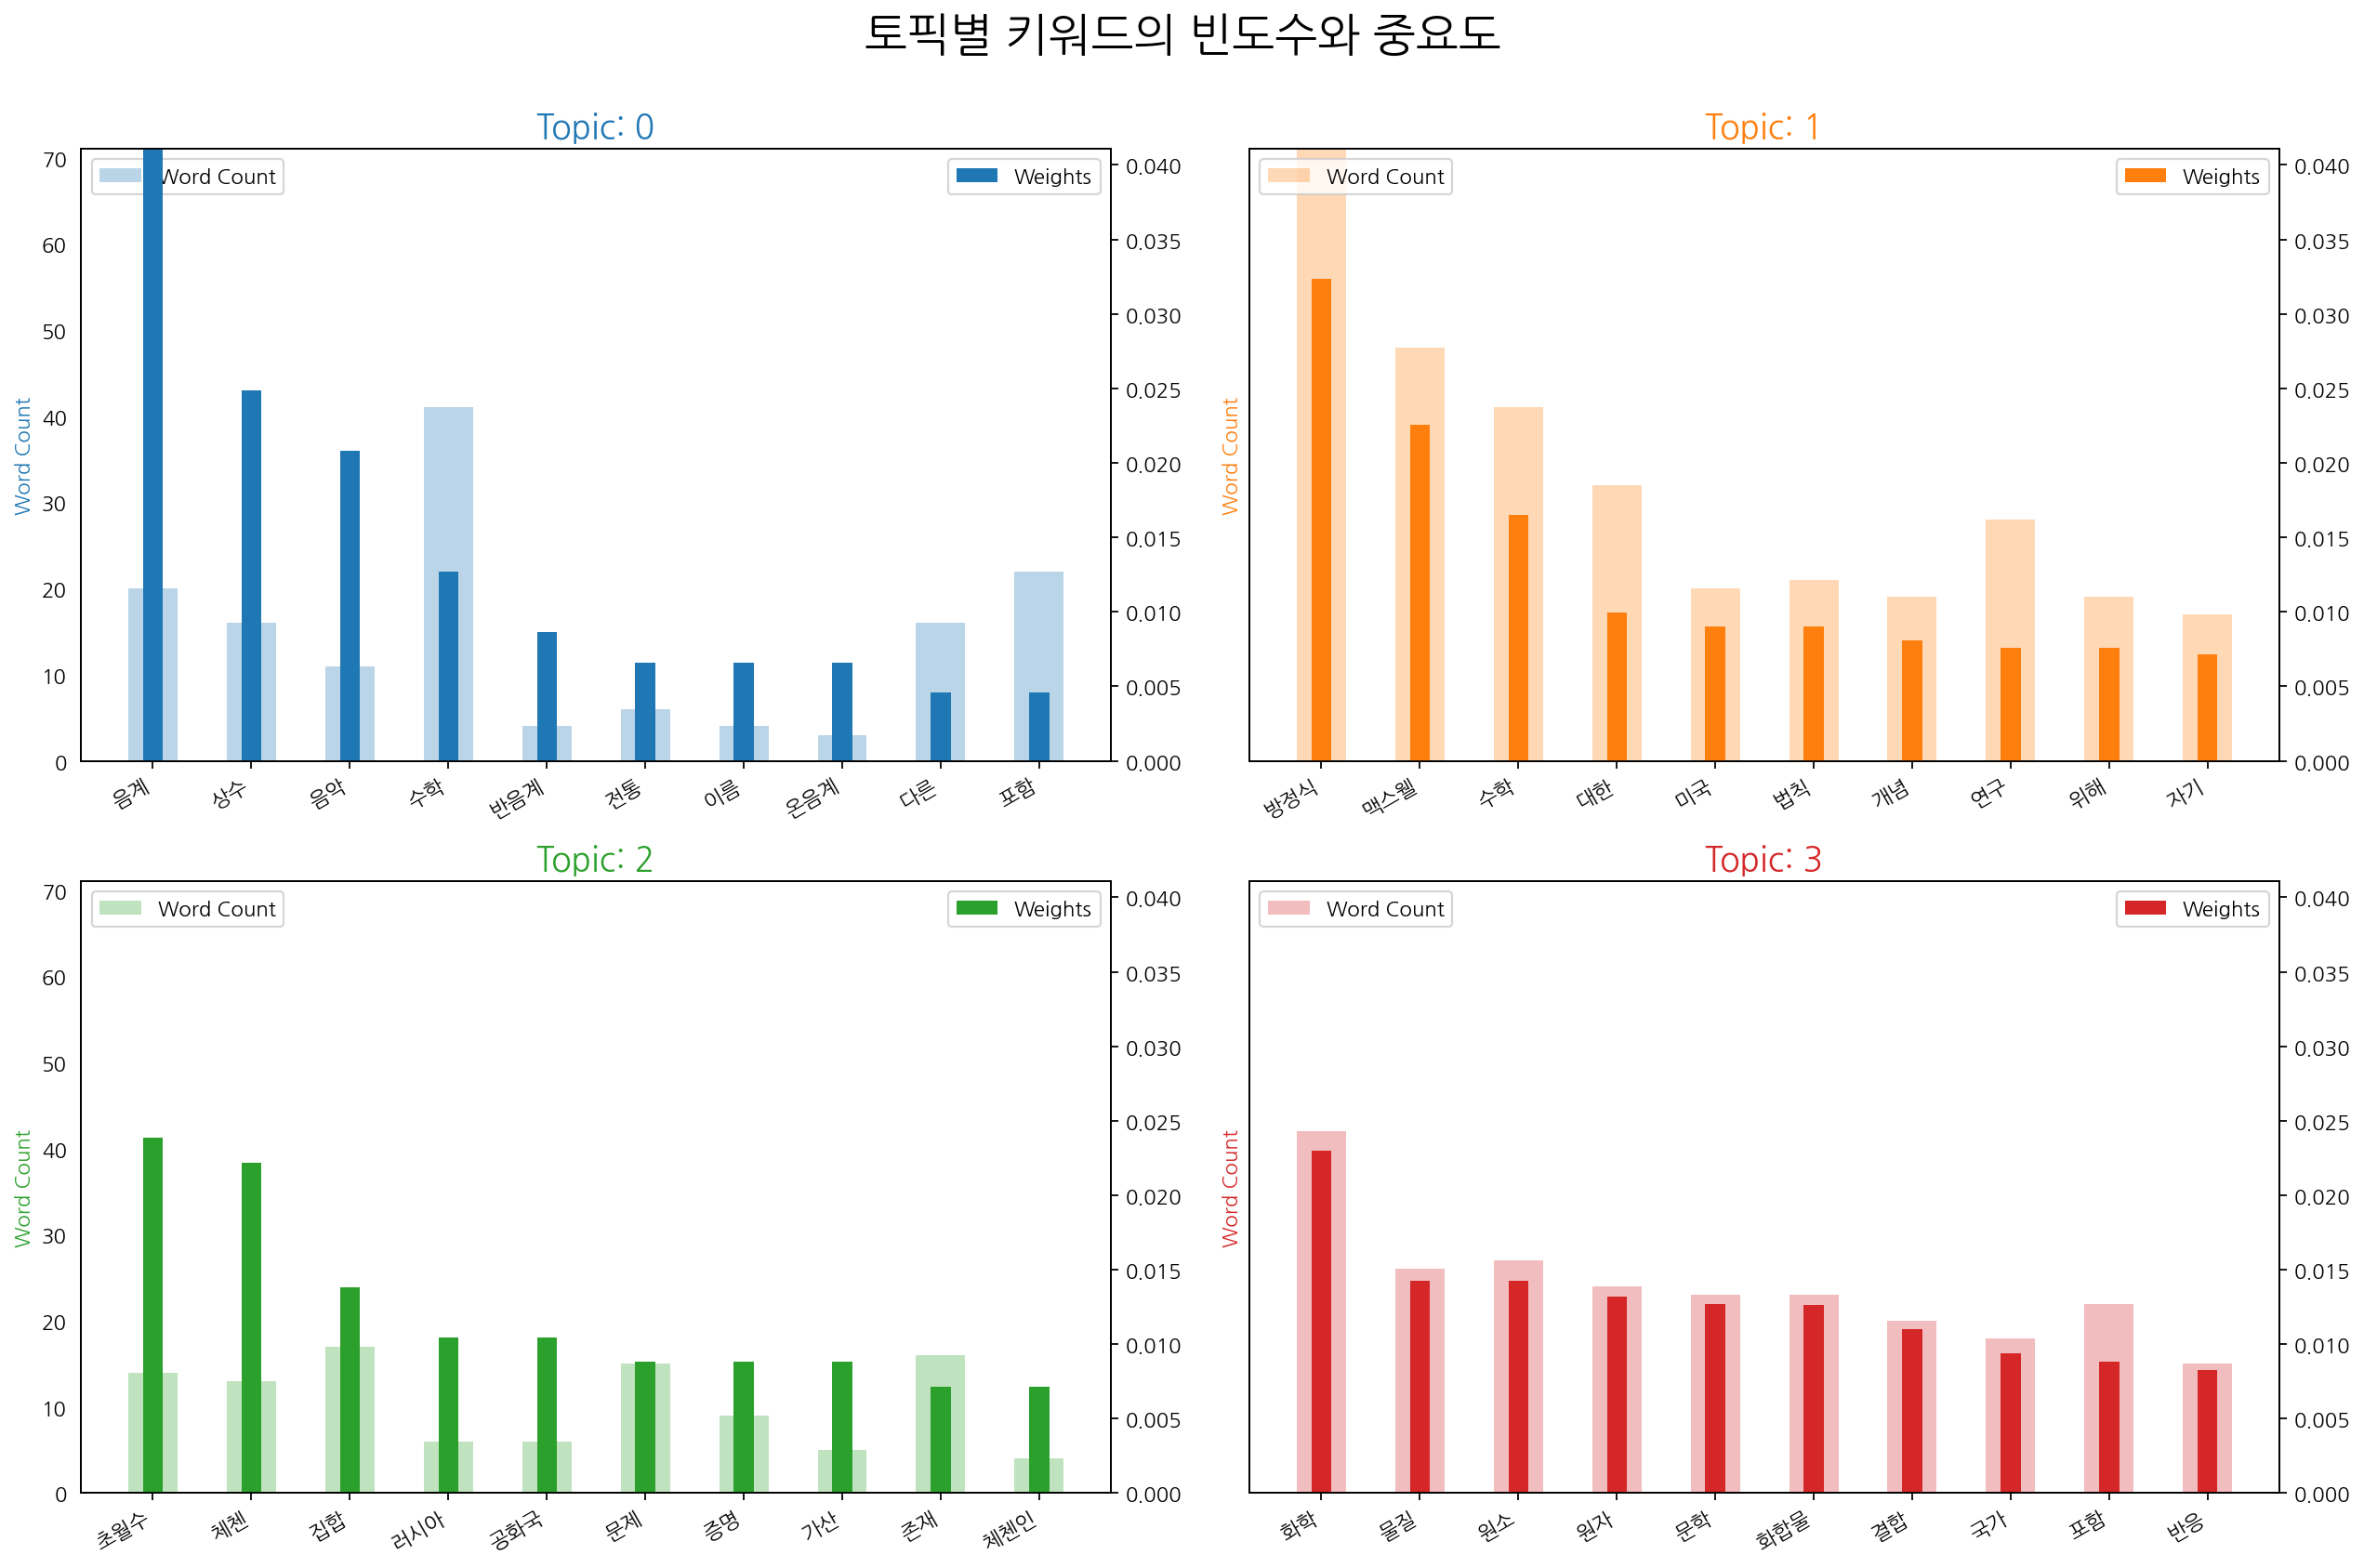

In [30]:
# 토픽별 키워드의 빈도수와 중요도 시각화
from collections import Counter
import matplotlib.font_manager as fm

topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in tdoc_list for w in w_list]
counter = Counter(data_flat)

# 주제별 토픽
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
fontpath ='/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumGothic')

# 토픽별 키워드의 빈도수와 중요도
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, max(df['importance'])); ax.set_ylim(0, max(df['word_count']))
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('토픽별 키워드의 빈도수와 중요도', fontsize=22, y=1.05)
# plt.savefig('토픽2.png')
plt.show()

In [31]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.3 MB/s eta 0:00:00


In [32]:
import pyLDAvis.gensim
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, g_corpus, g_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.134950  0.086442       1        1  48.455023
3     -0.156983  0.059913       2        1  40.314154
2      0.021118 -0.105237       3        1   7.025758
0      0.000915 -0.041118       4        1   4.205065, topic_info=     Term       Freq      Total Category  logprob  loglift
419    수학  32.000000  32.000000  Default  30.0000  30.0000
371   방정식  59.000000  59.000000  Default  29.0000  29.0000
1068   화학  34.000000  34.000000  Default  28.0000  28.0000
1168  맥스웰  41.000000  41.000000  Default  27.0000  27.0000
1323   음계   6.000000   6.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
52     대해   0.399729  16.792009   Topic4  -5.9701  -0.5690
890    서로   0.399710   5.855129   Topic4  -5.9702   0.4845
350    모든   0.398996   6.699441   Topic4  -5.9719   0.3481
283    경우   0.398958   8.361383   Topic4  -5.9720   0.1264
522    측정   0.398942   7.591625   Topic4  -5.9721   0.2229

[226 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1271      3  0.714480    가산
276       1  0.226394    가지
276       2  0.792377    가지
277       1  0.564026    각각
277       2  0.282013    각각
...     ...       ...   ...
1068      2  0.972190    화학
1070      2  0.907166   화학자
1071      2  0.978374   화합물
563       1  0.361818  힐베르트
563       3  0.361818  힐베르트

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])